In [3]:
from skimage import exposure, morphology, io, color
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [4]:
class COLORS:
    RED = {'a': 34, 'b': 1, 'tolerance': 10, 'price': 4}
    YELLOW = {'a': 10, 'b': 10, 'tolerance': 7, 'price': 3}
    BLUE = {'a': -15, 'b': -9, 'tolerance': 10, 'price': 2}
    GREEN = {'a': -15, 'b': 15, 'tolerance': 7, 'price': 1}

In [5]:
def load_image(url):
    img = np.zeros(1)
    try:
        img = io.imread(url)
    except Exception as e:
        print(f"Error while loading image: {str(e)}")
    return img

In [6]:
def plot_image(img, title=''):
    plt.figure(figsize=(20, 20))
    plt.rcParams['font.size'] = 20
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

In [7]:
def plot_points(img, y, x):
    plt.figure(figsize=(20, 20))
    plt.rcParams['font.size'] = 20
    plt.imshow(img, cmap='gray')
    plt.plot(x, y, 'ro', markersize=12)
    plt.show()

In [8]:
def compare_images(original_image, second_image):
    plt.figure(figsize=(40, 30))
    plt.rcParams['font.size'] = 50
    plt.subplot(121)
    plt.title('Original image')
    plt.imshow(original_image, cmap='gray')
    plt.subplot(122)
    plt.title('Segmented image')
    plt.imshow(second_image, cmap='gray')
    plt.show()

In [9]:
def convert_to_lab(img):
    return color.rgb2lab(img)

In [10]:
def segment_selected_color(img, a, b, tolerance=10):
    image_lab = convert_to_lab(img)
    image_lab = ((image_lab[:, :, 1] > a - tolerance) * (image_lab[:, :, 1] < a + tolerance)
                 * (image_lab[:, :, 2] > b - tolerance) * (image_lab[:, :, 2] < b + tolerance))
    return image_lab

In [11]:
def apply_morphology(image):
    image = morphology.opening(image, morphology.disk(10))
    image = morphology.dilation(image, morphology.disk(10))
    return image

In [12]:
def count_colored_mochi(image, colour):
    image_color = segment_selected_color(image, colour['a'], colour['b'], colour['tolerance'])
    image_color = apply_morphology(image_color)
    image_color, count, coords = watershed_segment(image_color)
    # compare_images(image, image_color)
    return count, coords

In [13]:
def watershed_segment(image):
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, footprint=np.ones((20, 20)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=image)
    count = len(np.unique(labels)) - 1
    return labels, count, coords

Red: 14, Yellow: 20, Blue: 9, Green: 14
Total price: 148


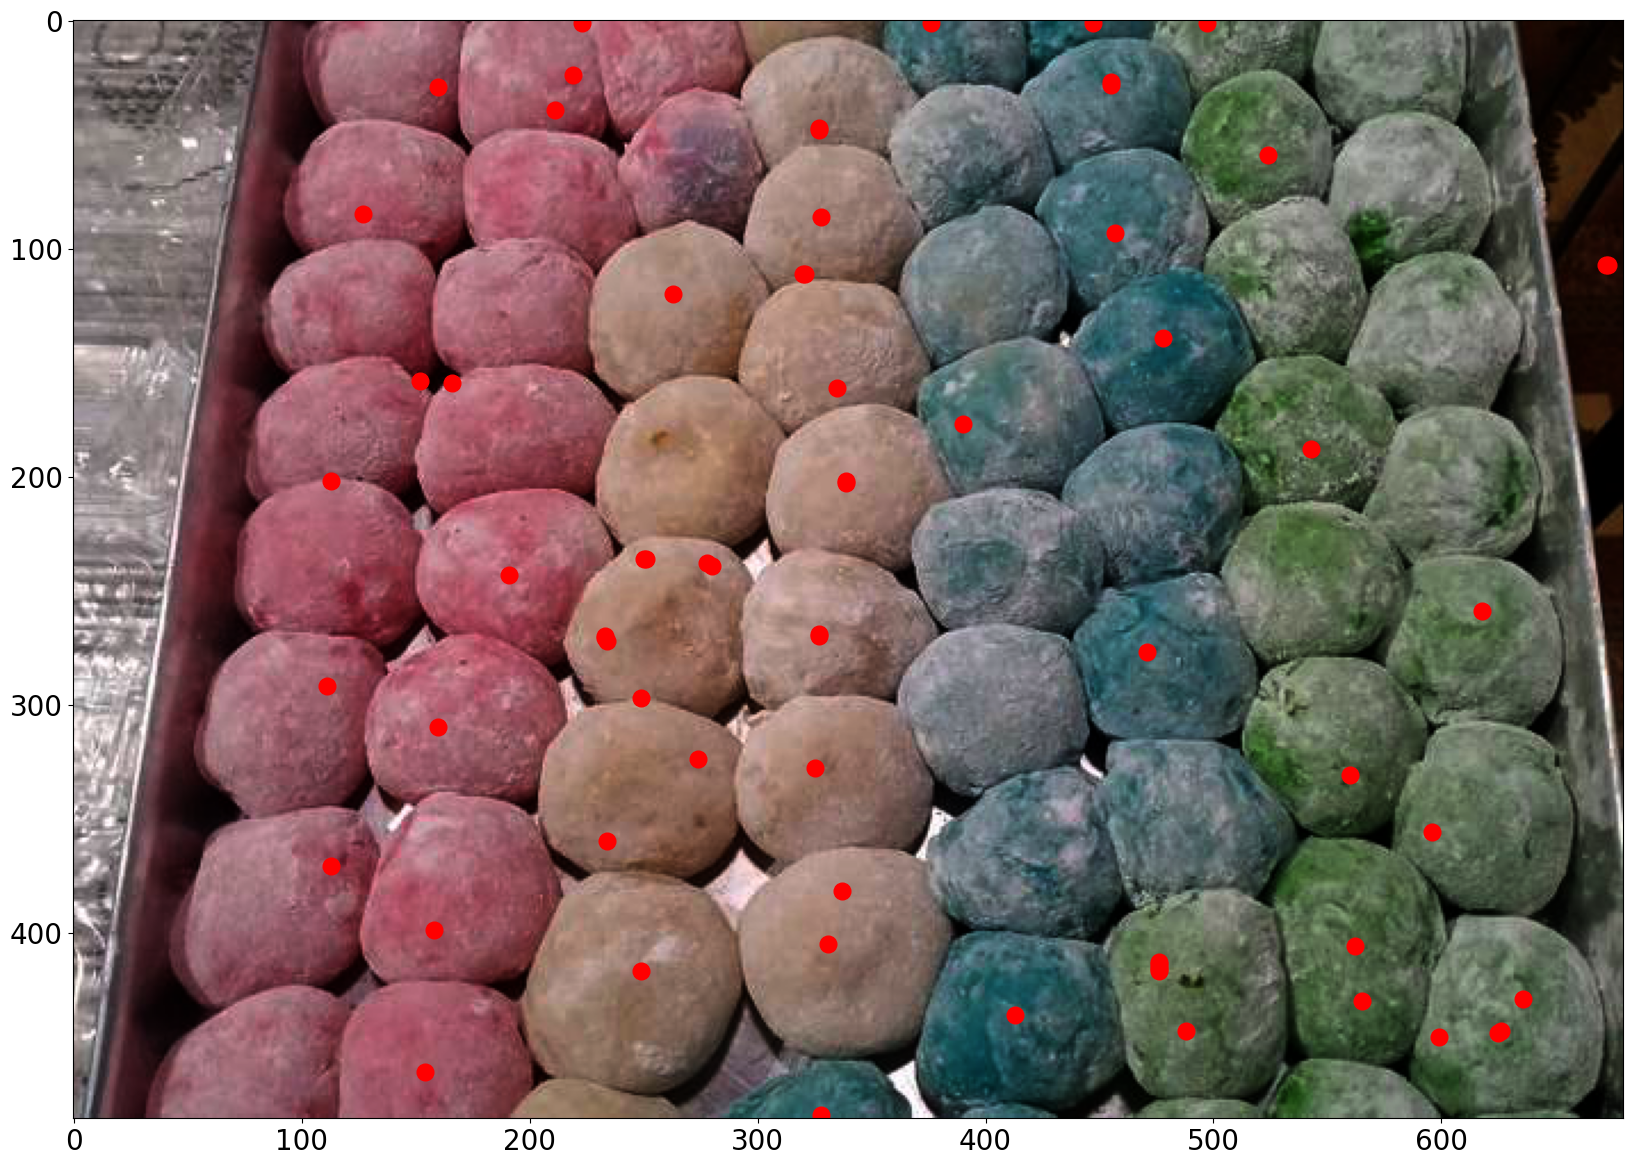

In [14]:
url = "data/mochi.jpeg"
image = load_image(url)

image = exposure.adjust_gamma(image, 2)

red_number, coords_red = count_colored_mochi(image, COLORS.RED)
yellow_number, coords_yellow = count_colored_mochi(image, COLORS.YELLOW)
blue_number, coords_blue = count_colored_mochi(image, COLORS.BLUE)
green_number, coords_green = count_colored_mochi(image, COLORS.GREEN)

print(f"Red: {red_number}, Yellow: {yellow_number}, Blue: {blue_number}, Green: {green_number}")
price = red_number * COLORS.RED['price'] + yellow_number * COLORS.YELLOW['price'] + blue_number * COLORS.BLUE['price'] + green_number * COLORS.GREEN['price']
print(f"Total price: {price}")
merged_coords = np.concatenate([coords_red, coords_yellow, coords_blue, coords_green], axis=0).tolist()

x, y = list(), list()
for i in range(len(merged_coords)):
    x.append(merged_coords[i][0])
    y.append(merged_coords[i][1])
plot_points(image, x, y)